In [1]:
import sys
sys.path.append(".")

In [2]:
import numpy as np
import glob
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras import layers
import matplotlib.pylab as plt
import pickle
from pathlib import Path
from PlayingCardsGenerator import CardsDataGenerator
from skimage.transform import resize

In [3]:
physical_devices = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [4]:
classes_names = ["2_clubs","2_diamonds","2_hearts","2_spades",\
               "3_clubs","3_diamonds","3_hearts","3_spades",\
               "4_clubs","4_diamonds","4_hearts","4_spades",\
               "5_clubs","5_diamonds","5_hearts","5_spades",\
               "6_clubs","6_diamonds","6_hearts","6_spades",\
               "7_clubs","7_diamonds","7_hearts","7_spades",\
               "8_clubs","8_diamonds","8_hearts","8_spades",\
               "9_clubs","9_diamonds","9_hearts","9_spades",\
               "10_clubs","10_diamonds","10_hearts","10_spades",\
               "ace_clubs","ace_diamonds","ace_hearts","ace_spades",\
               "jack_clubs","jack_diamonds","jack_hearts","jack_spades",\
               "king_clubs","king_diamonds","king_hearts","king_spades",\
               "queen_clubs","queen_diamonds","queen_hearts","queen_spades"]

In [5]:
gen_params = {"samplewise_center":True,\
              "samplewise_std_normalization":True}

In [6]:
generator = ImageDataGenerator(**gen_params, validation_split=0.15)

In [7]:
bs = 64 # batch size

In [8]:
path = Path("dataset/")

In [9]:
img_height = 256
img_width = 256

In [10]:
train_generator = generator.flow_from_directory(
    directory = path,
    target_size=(img_height, img_width),
    batch_size=bs,
    class_mode="categorical",
    subset='training',
    interpolation="nearest",
    shuffle=True,
    seed=69,
    classes=classes_names) # set as training data

Found 26518 images belonging to 52 classes.


In [11]:
validation_generator = generator.flow_from_directory(
    directory = path,
    target_size=(img_height, img_width),
    batch_size=bs,
    class_mode="categorical",
    subset='validation',
    interpolation="nearest",
    shuffle=True,
    seed=69,
    classes=classes_names) # set as validation data

Found 4648 images belonging to 52 classes.


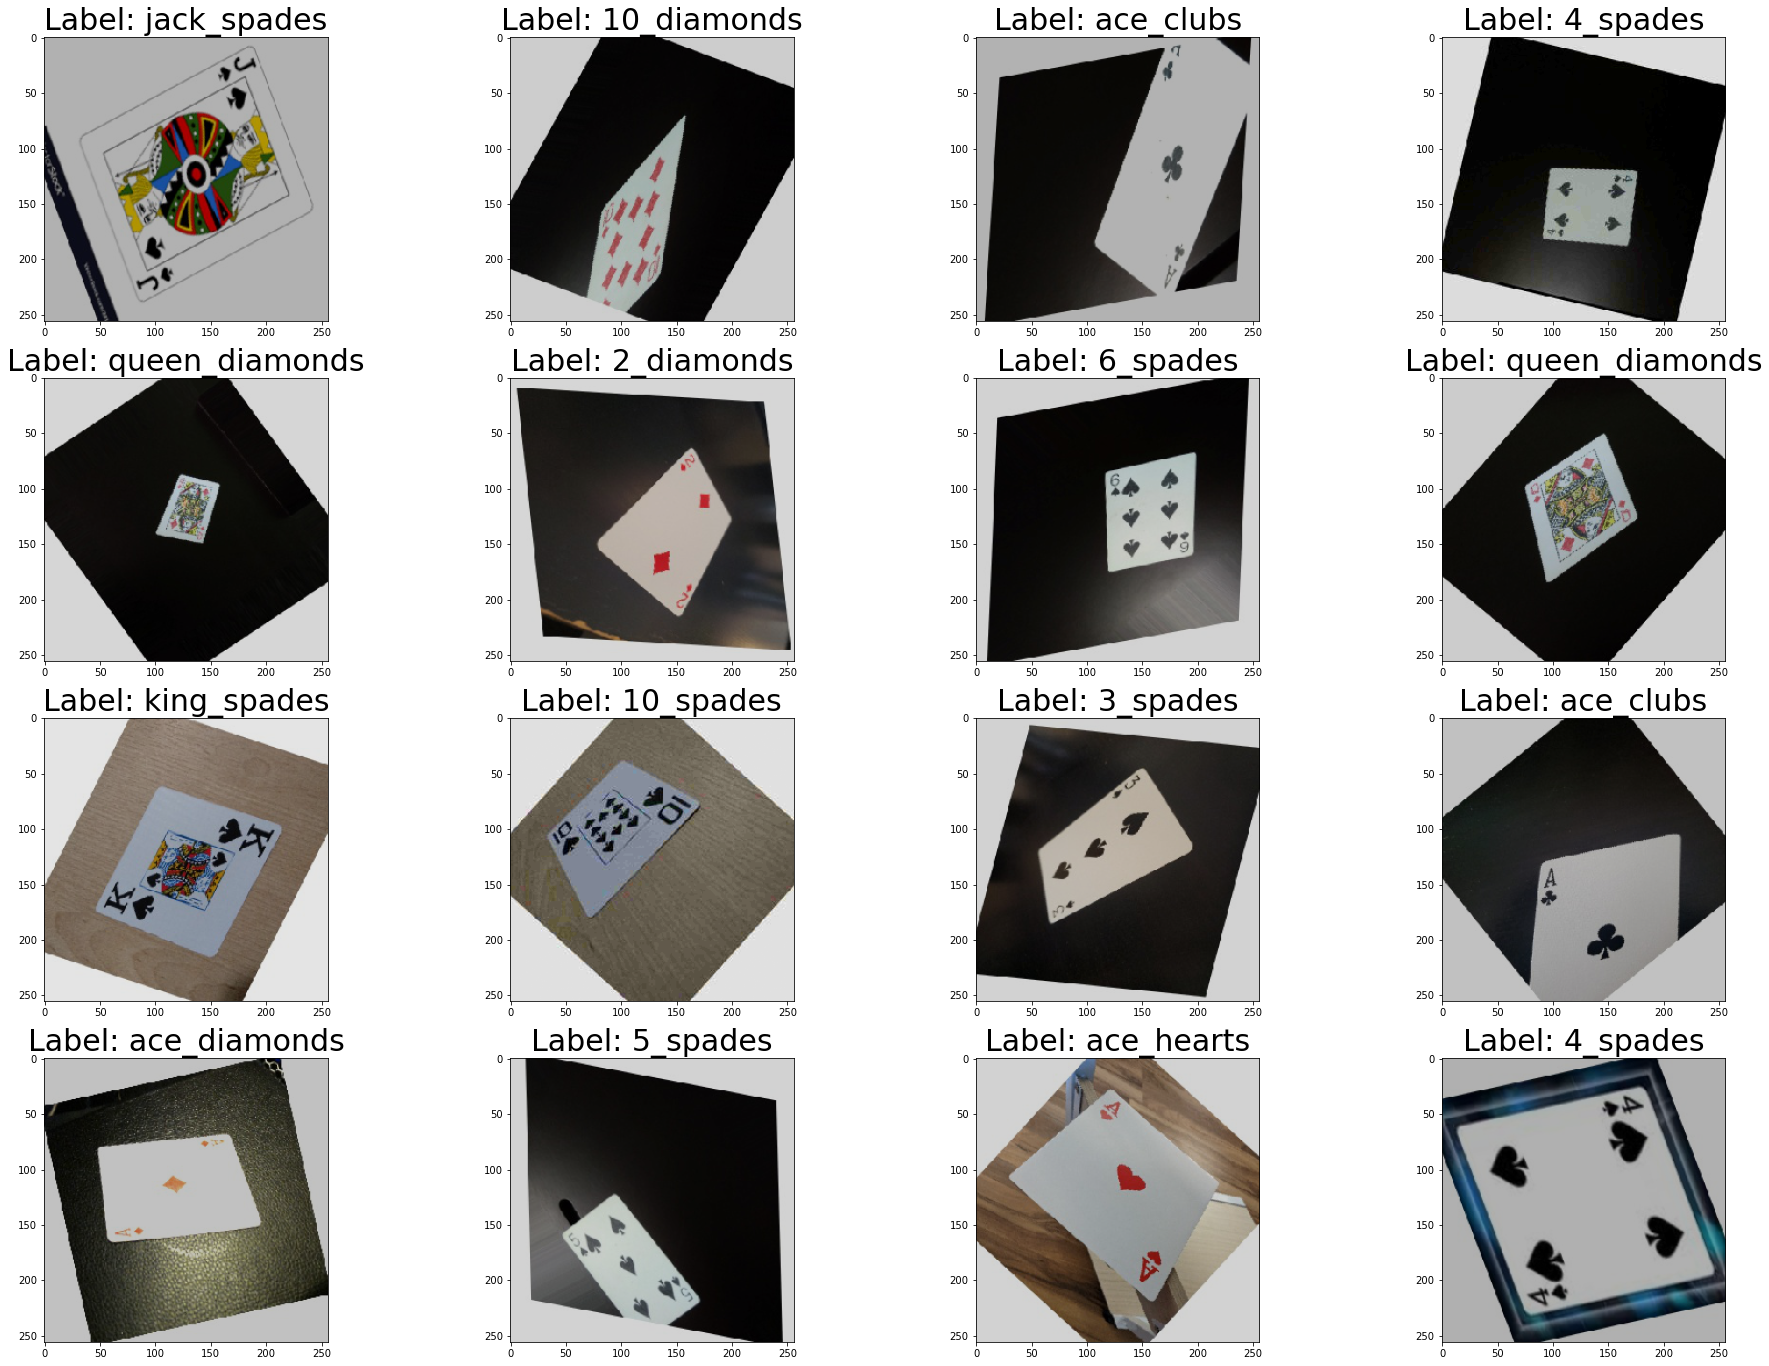

In [12]:
#Exploratory data analysis
Xbatch, Ybatch = train_generator.__getitem__(0)

plt.figure(figsize = (32,24))

labels = Ybatch

for ii in range(int(bs/4)):
    plt.subplot(4,4,ii+1)
    plt.imshow((Xbatch[ii]- Xbatch[ii].min())/(Xbatch.max() - Xbatch[ii].min()), cmap = "gray")
    label_idx = int(labels[ii].argmax())
    plt.title("Label: {}".format(classes_names[label_idx]),\
              fontsize=30)
plt.show()

In [13]:
ishape = (img_height, img_width, 3)
model_input = tf.keras.layers.Input(shape = ishape)

kernel_size = 3

l1 = tf.keras.layers.Conv2D(8, (kernel_size,kernel_size), activation='relu', padding="same")(model_input)
l2 = tf.keras.layers.Conv2D(8, (kernel_size,kernel_size), activation='relu', padding="same")(l1)
l3 = tf.keras.layers.MaxPooling2D(2, 2)(l2)
l4 = tf.keras.layers.Dropout(0.5)(l3)
l5 = tf.keras.layers.Conv2D(16, (kernel_size,kernel_size), activation='relu', padding="same")(l4)
l6 = tf.keras.layers.Conv2D(16, (kernel_size,kernel_size), activation='relu', padding="same")(l5)
l7 = tf.keras.layers.MaxPooling2D(2,2)(l6)
l8 = tf.keras.layers.Dropout(0.5)(l7)
l9 = tf.keras.layers.Conv2D(32, (kernel_size,kernel_size), activation='relu', padding="same")(l8)
l10 = tf.keras.layers.Conv2D(32, (kernel_size,kernel_size), activation='relu', padding="same")(l9)
l11 = tf.keras.layers.MaxPooling2D(2,2)(l10)
l12 = tf.keras.layers.Dropout(0.5)(l11)
l13 = tf.keras.layers.Conv2D(64, (kernel_size,kernel_size), activation='relu', padding="same")(l12)
l14 = tf.keras.layers.Conv2D(64, (kernel_size,kernel_size), activation='relu', padding="same")(l13)
l15 = tf.keras.layers.MaxPooling2D(2,2)(l14)
l16 = tf.keras.layers.Dropout(0.5)(l15)
l17 = tf.keras.layers.Conv2D(128, (kernel_size,kernel_size), activation='relu', padding="same")(l16)
l18 = tf.keras.layers.Conv2D(128, (kernel_size,kernel_size), activation='relu', padding="same")(l17)
l19 = tf.keras.layers.MaxPooling2D(2,2)(l18)
l20 = tf.keras.layers.Dropout(0.5)(l19)
l21 = tf.keras.layers.Conv2D(256, (kernel_size,kernel_size), activation='relu', padding="same")(l20)
l22 = tf.keras.layers.Conv2D(256, (kernel_size,kernel_size), activation='relu', padding="same")(l21)

l23 = tf.keras.layers.GlobalAveragePooling2D()(l22)
l24 = tf.keras.layers.Dropout(0.5)(l23)
l24 = tf.keras.layers.Flatten()(l23)

#to make sure this is as close as possible to the two outputs model, keep the dense layer with 17 neurons
classifier = tf.keras.layers.Dense(17, activation = 'relu')(l24)

out = tf.keras.layers.Dense(len(classes_names) , activation = 'softmax')(classifier)

model = tf.keras.Model(inputs = model_input, outputs = out)

In [14]:
print("Model Summary:")
print(model.summary())

Model Summary:
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 256, 256, 8)       224       
                                                                 
 conv2d_1 (Conv2D)           (None, 256, 256, 8)       584       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 128, 128, 8)      0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 128, 128, 8)       0         
                                                                 
 conv2d_2 (Conv2D)           (None, 128, 128, 16)      1168      
                                              

In [15]:
def scheduler(epoch, lr):
    if epoch%25 == 0 and epoch!= 0:
        lr = lr/(1.5)
    return lr

filepath_name='model_{epoch:d}.h5'

monitor_it = tf.keras.callbacks.ModelCheckpoint(filepath = filepath_name , monitor='val_loss',\
                                             verbose=1,save_best_only=False,\
                                             save_weights_only=False,\
                                             mode='auto',\
                                             save_freq='epoch')

early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience = 40, min_delta=0.001)

lr_schedule = tf.keras.callbacks.LearningRateScheduler(scheduler,verbose = 0)

In [16]:
num_epochs = 1000
init_lr = 0.5e-4
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate = init_lr),\
              loss='categorical_crossentropy',\
              metrics=['accuracy'])

In [17]:
history_it = model.fit(train_generator, epochs=num_epochs, verbose = 1, \
                       workers=8, validation_data = (validation_generator),\
                       callbacks= [monitor_it, early_stop, lr_schedule], shuffle=True, initial_epoch=0)

Epoch 1/1000
415/415 [==============================] - ETA: 0s - loss: 3.9513 - accuracy: 0.0206
Epoch 1: saving model to model_1.h5
415/415 [==============================] - 51s 112ms/step - loss: 3.9513 - accuracy: 0.0206 - val_loss: 3.9488 - val_accuracy: 0.0204 - lr: 5.0000e-05
Epoch 2/1000
415/415 [==============================] - ETA: 0s - loss: 3.8153 - accuracy: 0.0301
Epoch 2: saving model to model_2.h5
415/415 [==============================] - 44s 105ms/step - loss: 3.8153 - accuracy: 0.0301 - val_loss: 3.7208 - val_accuracy: 0.0379 - lr: 5.0000e-05
Epoch 3/1000
415/415 [==============================] - ETA: 0s - loss: 3.2967 - accuracy: 0.0809
Epoch 3: saving model to model_3.h5
415/415 [==============================] - 42s 99ms/step - loss: 3.2967 - accuracy: 0.0809 - val_loss: 3.5041 - val_accuracy: 0.0396 - lr: 5.0000e-05
Epoch 4/1000
415/415 [==============================] - ETA: 0s - loss: 3.0341 - accuracy: 0.1246
Epoch 4: saving model to model_4.h5
415/415 [===

Epoch 30/1000
415/415 [==============================] - ETA: 0s - loss: 1.8375 - accuracy: 0.4339
Epoch 30: saving model to model_30.h5
415/415 [==============================] - 40s 96ms/step - loss: 1.8375 - accuracy: 0.4339 - val_loss: 3.9055 - val_accuracy: 0.0850 - lr: 3.3333e-05
Epoch 31/1000
415/415 [==============================] - ETA: 0s - loss: 1.8280 - accuracy: 0.4348
Epoch 31: saving model to model_31.h5
415/415 [==============================] - 40s 95ms/step - loss: 1.8280 - accuracy: 0.4348 - val_loss: 3.9652 - val_accuracy: 0.0932 - lr: 3.3333e-05
Epoch 32/1000
415/415 [==============================] - ETA: 0s - loss: 1.8028 - accuracy: 0.4442
Epoch 32: saving model to model_32.h5
415/415 [==============================] - 40s 96ms/step - loss: 1.8028 - accuracy: 0.4442 - val_loss: 3.9773 - val_accuracy: 0.0970 - lr: 3.3333e-05
Epoch 33/1000
415/415 [==============================] - ETA: 0s - loss: 1.7837 - accuracy: 0.4516
Epoch 33: saving model to model_33.h5
41

Epoch 59/1000
415/415 [==============================] - ETA: 0s - loss: 1.3899 - accuracy: 0.5641
Epoch 59: saving model to model_59.h5
415/415 [==============================] - 38s 92ms/step - loss: 1.3899 - accuracy: 0.5641 - val_loss: 3.9030 - val_accuracy: 0.1059 - lr: 2.2222e-05
Epoch 60/1000
415/415 [==============================] - ETA: 0s - loss: 1.3807 - accuracy: 0.5637
Epoch 60: saving model to model_60.h5
415/415 [==============================] - 39s 92ms/step - loss: 1.3807 - accuracy: 0.5637 - val_loss: 3.9605 - val_accuracy: 0.1033 - lr: 2.2222e-05
Epoch 61/1000
415/415 [==============================] - ETA: 0s - loss: 1.3680 - accuracy: 0.5720
Epoch 61: saving model to model_61.h5
415/415 [==============================] - 39s 91ms/step - loss: 1.3680 - accuracy: 0.5720 - val_loss: 3.9751 - val_accuracy: 0.0992 - lr: 2.2222e-05
Epoch 62/1000
415/415 [==============================] - ETA: 0s - loss: 1.3572 - accuracy: 0.5730
Epoch 62: saving model to model_62.h5
41

Epoch 88/1000
415/415 [==============================] - ETA: 0s - loss: 1.1752 - accuracy: 0.6272
Epoch 88: saving model to model_88.h5
415/415 [==============================] - 39s 92ms/step - loss: 1.1752 - accuracy: 0.6272 - val_loss: 3.9776 - val_accuracy: 0.1343 - lr: 1.4815e-05
Epoch 89/1000
415/415 [==============================] - ETA: 0s - loss: 1.1537 - accuracy: 0.6349
Epoch 89: saving model to model_89.h5
415/415 [==============================] - 38s 91ms/step - loss: 1.1537 - accuracy: 0.6349 - val_loss: 3.9701 - val_accuracy: 0.1297 - lr: 1.4815e-05
Epoch 90/1000
415/415 [==============================] - ETA: 0s - loss: 1.1529 - accuracy: 0.6343
Epoch 90: saving model to model_90.h5
415/415 [==============================] - 38s 91ms/step - loss: 1.1529 - accuracy: 0.6343 - val_loss: 3.9976 - val_accuracy: 0.1375 - lr: 1.4815e-05
Epoch 91/1000
415/415 [==============================] - ETA: 0s - loss: 1.1434 - accuracy: 0.6369
Epoch 91: saving model to model_91.h5
41

415/415 [==============================] - 39s 93ms/step - loss: 1.0361 - accuracy: 0.6714 - val_loss: 4.1639 - val_accuracy: 0.1396 - lr: 9.8765e-06
Epoch 117/1000
415/415 [==============================] - ETA: 0s - loss: 1.0293 - accuracy: 0.6715
Epoch 117: saving model to model_117.h5
415/415 [==============================] - 39s 93ms/step - loss: 1.0293 - accuracy: 0.6715 - val_loss: 4.1429 - val_accuracy: 0.1414 - lr: 9.8765e-06
Epoch 118/1000
415/415 [==============================] - ETA: 0s - loss: 1.0231 - accuracy: 0.6725
Epoch 118: saving model to model_118.h5
415/415 [==============================] - 39s 92ms/step - loss: 1.0231 - accuracy: 0.6725 - val_loss: 4.2529 - val_accuracy: 0.1377 - lr: 9.8765e-06
Epoch 119/1000
415/415 [==============================] - ETA: 0s - loss: 1.0190 - accuracy: 0.6738
Epoch 119: saving model to model_119.h5
415/415 [==============================] - 39s 93ms/step - loss: 1.0190 - accuracy: 0.6738 - val_loss: 4.2830 - val_accuracy: 0.13

Epoch 145/1000
415/415 [==============================] - ETA: 0s - loss: 0.9483 - accuracy: 0.6978
Epoch 145: saving model to model_145.h5
415/415 [==============================] - 39s 92ms/step - loss: 0.9483 - accuracy: 0.6978 - val_loss: 4.2619 - val_accuracy: 0.1450 - lr: 6.5844e-06
Epoch 146/1000
415/415 [==============================] - ETA: 0s - loss: 0.9540 - accuracy: 0.6927
Epoch 146: saving model to model_146.h5
415/415 [==============================] - 42s 99ms/step - loss: 0.9540 - accuracy: 0.6927 - val_loss: 4.2045 - val_accuracy: 0.1517 - lr: 6.5844e-06
Epoch 147/1000
415/415 [==============================] - ETA: 0s - loss: 0.9486 - accuracy: 0.6996
Epoch 147: saving model to model_147.h5
415/415 [==============================] - 42s 100ms/step - loss: 0.9486 - accuracy: 0.6996 - val_loss: 4.3363 - val_accuracy: 0.1480 - lr: 6.5844e-06
Epoch 148/1000
415/415 [==============================] - ETA: 0s - loss: 0.9489 - accuracy: 0.6942
Epoch 148: saving model to mo

415/415 [==============================] - ETA: 0s - loss: 0.9055 - accuracy: 0.7129
Epoch 173: saving model to model_173.h5
415/415 [==============================] - 42s 100ms/step - loss: 0.9055 - accuracy: 0.7129 - val_loss: 4.4163 - val_accuracy: 0.1515 - lr: 4.3896e-06
Epoch 174/1000
415/415 [==============================] - ETA: 0s - loss: 0.9047 - accuracy: 0.7108
Epoch 174: saving model to model_174.h5
415/415 [==============================] - 42s 100ms/step - loss: 0.9047 - accuracy: 0.7108 - val_loss: 4.3804 - val_accuracy: 0.1502 - lr: 4.3896e-06
Epoch 175/1000
415/415 [==============================] - ETA: 0s - loss: 0.9098 - accuracy: 0.7104
Epoch 175: saving model to model_175.h5
415/415 [==============================] - 42s 100ms/step - loss: 0.9098 - accuracy: 0.7104 - val_loss: 4.3239 - val_accuracy: 0.1491 - lr: 4.3896e-06
Epoch 176/1000
415/415 [==============================] - ETA: 0s - loss: 0.8946 - accuracy: 0.7142
Epoch 176: saving model to model_176.h5
41

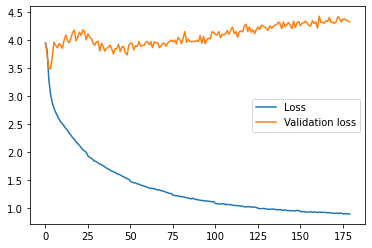

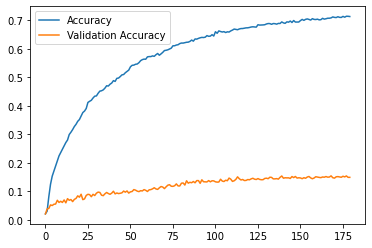

In [18]:
plt.figure()
plt.plot(history_it.history["loss"], label = "Loss")
plt.plot(history_it.history["val_loss"], label = "Validation loss")
plt.legend()

plt.figure()
plt.plot(history_it.history["accuracy"], label = "Accuracy")
plt.plot(history_it.history["val_accuracy"], label = "Validation Accuracy")
plt.legend()

plt.show()

In [23]:
test_generator = ImageDataGenerator(**gen_params)

path_test = Path("dataset_test/")

bs = 64

test_generator_flow = test_generator.flow_from_directory(
    directory = path_test,
    target_size=(img_height, img_width),
    batch_size=bs,
    class_mode="categorical",
    interpolation="nearest",
    shuffle=True,
    seed=21,
    classes=classes_names)

#sample 50 batches to check accuracy
acc = []
for i in range(50):
    Xbatch, Ybatch = test_generator_flow.__getitem__(i)
    metrics = model.evaluate(Xbatch, Ybatch)
    acc.append(metrics[1])
    
acc = np.array(acc)
    
print("Acc mean {}".format(np.mean(acc)))
print("Acc std {}".format(np.std(acc)))


Found 7794 images belonging to 52 classes.
2/2 [==============================] - 0s 128ms/step - loss: 5.7937 - accuracy: 0.1250
Acc mean 0.15125
Acc std 0.04681663032513126
